# Assignment 2 - DS4Biz Y63

## TextScraping_Classification

### Team Detail
#### Team Name: INu


### Student 1

<b>Student ID:</b> 61070285<br>
<b>Student Full Name:</b> นายชยพล วนานิยกุล

### Student 2

<b>Student ID:</b> 61070327<br>
<b>Student Full Name:</b>นายอนุ ม่วงคำ

In [1]:
import requests
import bs4
import pandas as pd
import numpy as np
import sys
import warnings
from sklearn.feature_extraction.text import CountVectorizer
import operator
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, \
precision_recall_curve, average_precision_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Function Scraping
เป็นขั้นตอนการดึงข้อมูลจากเว็บ และบันทึกลงไฟล์ text โดยจะแบ่งออกเป็น 6 ฟังชั่นดังนี้
1.  <b>request_month()</b>  เป็นฟังชั่นที่ใช้ในการดึงลิ้งข่าวของแต่ละเดือน มาเก็บไว้ใน list 


2.  <b>category_three(web_month)</b> ทำหน้าในการดึงข้อมูล Category ของข่าวมาเก็บไว้ใน list


3.  <b>path_text(web_month)</b> เป็นฟังชั่นที่่ใช้ในการเก็บลิ้งเนื้อหาข่าวทั้งหมด ที่อยู่บน website มาเก็บไว้ใน list


4.  <b>extract_text(web_month)</b> เป็นฟังชั่นในการเก็บเนื้อหาข่าวทั้งหมด


5.  <b>create_file_category(category)</b> ฟังชั่นบันทึก categoryเป็นไฟล์ txt.


6.  <b>create_file_text (text) </b> ฟั่งชั่นบันทึกเนื้อหาข่าวเป็นไฟล์ Txt.

In [2]:
#parameter web_month ที่อยู่ในฟังชั่นนั้น เวลาเรียกใช้งานฟังชั่นต้องใส่ฟังชั่น request_month() เข้าไปแทน เช่น  category_three(request_month())เป็นต้น.

def request_month(): # ฟังชั่นดึง ลิ้งข้อมูลของแต่ละเดือน
    response = requests.get('http://www.it.kmitl.ac.th/~teerapong/news_archive/index.html') #กำหนดหน้าลิ้งหลัก
    html_page = bs4.BeautifulSoup(response.content, 'lxml')
    selector = 'li > a'         # กำหนดการเข้าถึง tags  เนื่องจากเราต้องการเข้า tag ที่เก็บลิ้งของแต่ละเดือนจึงเข้าไปที่ tag a
    tags_month = html_page.select(selector)  #กำหนดให้ beautifulsoup ไปดึงข้อมูลจาก tags ที่อยู่ในตัวแปร selector
    list_tag = []
                           # เนื่องจาก่สิ่งที่ได้จาก tag month เป็นเพียง path ของ link 
    for tag in tags_month: # จึงทำการวนลูป tags_month เพื่อเชื่อมให้ path กับ link เข้าด้วยกัน และเก็บเป็น list ที่มีลิ้งข่าวของแต่ละเดือน
        list_tag.append('http://www.it.kmitl.ac.th/~teerapong/news_archive/'+tag['href']) #และเก็บไว้ใน list
    return list_tag         #โดยผลลัพธ์จะเป็นลิ้งเดือนทั้งหมด

def category_three(web_month): # ฟังชั่น เก็บข้อมูลประเภทของข่าว   
    category_list = []
    for web in request_month(): #โดยขั้นตอนนี้จะทำการวนลูปลิ้งข่าวแต่ละเดือน ซึ่งจะเริ่มตั้งแต่เดือน 1 ถึง 12 
        count = 0
        response = requests.get(str(web))     #กำหนดหน้าลิ้งข่าวที่จะดึง
        html_page = bs4.BeautifulSoup(response.content, 'lxml')
        selector_ = 'tbody > tr > td'          #กำหนดการเข้าถึง tag   เนื่องจาก category ของข่าวถูกเก็บไว้ใน tbody และเก็บในส่วนของ td 
        tags_category = html_page.select(selector_)     #กำหนดให้ beautifulsoup ไปดึงข้อมูลจาก tags ที่อยู่ในตัวแปร selector_
        
        for tag in tags_category: #หลังจากนั้นทำการวนลูปเพื่อดึง category ทั้งหมดของเดือนดังกล่าว มาเก็บไว้ใน list
                                                # เนื่องจากตอนดึง html_page.select จะดึงข้อมูลออกมาเป็นคู่ ซึ่ง 1เรือง จะมี 2 tag คู่กันเสมอ
                                                # คือ tag category และ tag หัวข้อเรื่อง ซึ่งเราสนใจแค่ tag category
            if (count % 2 == 0) and (str(tag.text[1:]) != 'N/A'): #จึงทำการกำหนดเงื่อนไขให้เก็บเฉพาะ tag ตัวแรกของแต่ละข่าว ซึ่งก็คือ
                                                       # tag category โดยกำหนด count % 2 == 0 และทำการดักข่าวที่ไม่มี category
                                                       # โดย ดัก category นั้นว่าต้อง != N/A
                category_list.append(tag.text[1:])    #หลังจากนั้นนำ category มาเก็บไว้ใน list
            count += 1
    return category_list #โดยผลลัพธ์จะเป็น category ของข่าวทั้งหมดที่มีอยู่ใน web


def path_text(web_month):    # ฟั่งชั่นเก็บลิ้งเนื้อหาของข่าวทั้งหมด
    list_path = []
    for  web in request_month():     #จะทำการวนลูปลิ้งข่าวของแต่ละเดือน  ซึ่งจะเริ่มตั้งแต่เดือน 1 ถึง 12
        response = requests.get(str(web)) #กำหนดหน้าลิ้งข่าวที่จะดึง
        html_page = bs4.BeautifulSoup(response.content, 'lxml')
        selector_text = 'tbody > tr > td > a ' #กำหนดการเข้าถึง tag โดยจะมุ่งไปที่ข่าวที่อยู่ในเดือนนั้น ๆ  
        tags_text = html_page.select(selector_text) #กำหนดให้ beautifulsoup ไปดึงข้อมูลจาก tags ที่อยู่ในตัวแปร selector_text
                                                    #โดยผลลัพธ์จะเป็น path ของ ข่าวแต่ละข่าว ที่อยู่ในเดือนนั้นๆ 
        for path in tags_text:        #จากนั้นทำการวนลูป path ของข่าวทั้งหมดที่อยู่ในเดือนนั้น เพื่อรวม link เข้ากับ path ของข่าว
            list_path.append('http://www.it.kmitl.ac.th/~teerapong/news_archive/'+ str(path['href'])) #และเก็บไว้ใน list
    return list_path #โดยผลลัพธ์จะเป็นลิ้งข่าวทั้งหมดที่มีอยู่ใน web


def extract_text(web_month): #ฟังชั่นเก็บเนื้อหาข่าว
    long_text = []
    list_head = []
    for web in path_text(request_month()): #โดยจะเป็นการวนลูปลิ้งเนื้อหาของข่าวทั้งหมด 
        text_box = ''
        response = requests.get(web)  #กำหนดลิ้งข่าว
        html_page = bs4.BeautifulSoup(response.content, 'lxml')
        selector_head = 'h2' #ในขั้นตอนการกำหนดการเข้าถึง tag เราจะทำการกำหนด 2 ตัว คือ selector_head ไว้ใช้ดึงหัวข้อข่าว
        selector_text = 'p ' #และ  selector_text ไว้ใช้ดึงเนื้อหาข่าว
        tags_body = html_page.select(selector_text) #กำหนดให้ beautifulsoup ไปดึงข้อมูลจาก tags ที่อยู่ในตัวแปร selector_text
        tags_head = html_page.select(selector_head) #กำหนดให้ beautifulsoup ไปดึงข้อมูลจาก tags ที่อยู่ในตัวแปร selector_head
        for  head in tags_head: #เนื่องจากผลลัพธ์ของ tags_head จะเป็นข้อมูลหัวเรื่องของแต่ละข่าว จึงวนลูปเพื่อมาเก็บไว้ใน list
            list_head.append(head.text)
        for text in tags_body:    #เนื่องจากในเนื้อหาข่าว    ส่วนของ htmlข้อมูลจะเป็นลักษณะ pharagrap โดย 1 ข่าวจะมีหลาย pharagrap 
                                  # จึงทำการวนลูปเพื่อดึงเนื้อหาข่าวจากทุก ๆ pharagrap
            if (text.text in list_head): # และทำการดักเนื้อหาข่าวกรณี หัวข้อข่าวเป็น tag p และนำมารวมกับเนื้อหา 
                pass                     # โดยถ้า text นั้นอยู่ใน list หัวข้อข่าว ให้ข้ามไป
            elif (('class='  in str(text)) == False): #และทำการดัก text   ที่เป็น tag ปุ่มกลับ เช่น Return to article search results
                                                      #โดยเช็คว่าใน text นั้นมีคำclass= อยู่รึป่าว ? 
                text_box += str(text.text)            #โดยถ้า text ไม่มี claas อยู่ข้างในให้เพิ่ม ไปใน string text_box 
                                                      # เพื่อรวมหลายๆ pharagrap ไว้ด้วยกัน จนกลายเป็น 1 ข่าว 
        text_box = text_box.replace("\"","")          # เนื่องจากในแต่ละข่าว \ อยู่ จึงทำการ replace ให้เป็น ""
        long_text.append(text_box)                    # จากนั้นให้นำข่าวที่เป็น sting มาเก็บไว้ใน list 
    return long_text #โดยผลลัพธ์จะเป็น list ของเนื้อหาข่าวทั้งหมด

def create_file_category (category): # ฟังชั่นบันทึก categoryเป็นไฟล์ text
    out_file = open("target/category.txt", "w") #โดยใช้คำสั่ง open เพื่อเปิดไฟล์ กรณีไม่มีจะทำการสร้างขึ้นมาเอง
    for target in category_three(request_month()): #จากนั้นทำการวนลูปไปใน list ของ category
        out_file.write(target+"\n")                #และเขียนแต่ละ category ลงไฟล์ ละเพิ่ม '\n' เพื่อให้ 1 category = 1 บรรทัด
    out_file.close()                               #สุดท้ายคือการใช้คำสั่งเซฟไฟล์
    
def create_file_text (text): # ฟั่งชั่นบันทึกเนื้อหาข่าวเป็น Text
    out_file = open("datastore/news_text.txt", "w",encoding="utf-8") #โดยใช้คำสั่ง open เพื่อเปิดไฟล์ กรณีไม่มีจะทำการสร้างขึ้นมาเอง
    for sentence in extract_text(path_text(request_month())):         #จากนั้นทำการวนลูปไปใน list ของเนื้อหาข่าว 
        out_file.write(sentence + '\n')                            #และเขียนแต่ละข่าวลงไฟล์ ละเพิ่ม '\n' เพื่อให้ 1 ข่าว = 1 บรรทัด
    out_file.close()                                               #สุดท้ายคือการใช้คำสั่งเซฟไฟล์

# Parse the collected data, and store it in an appropriate file format
ขั้นตอนการบันทึกข้อมูลลงไฟล์ .txt ใช้ 2 กระบวนการ
1. <b>create_file_category(category_three(request_month()))</b>  โดยจะใช้ฟังชั่น request_month เพื่อข้อมูลของแต่ละเดือนออกมา จากนั้นใช้ฟังชั่น category_three เพื่อเข้าถึงข้อมูลแต่ละเดือนและทำการสกัดเอา category ของแต่ละข่าวออกมา หลังจากนั้นใช้ create_file_category เพื่อบันทึกเป็นไฟล์ Category.txt


2. <b>create_file_text (extract_text(path_text(request_month())))</b> #จะเริ่มจากใช้ฟังชั่น request_month เพื่อข้อมูลของแต่ละเดือนออกมา จากนั้นใช้ฟังชั่น path_text เพื่อสกัดเอาลิ้งข่าวของแต่ละเดือนออกมา หลังจากนั้นใช้ฟังชั่น extract_text เพื่อสกัดเอาเนื้อข่าวของแต่ละข่าว และสุดท้ายใช้ฟังชั่น create_file_text เพื่อบันทึกเป็นไฟล์ News.txt

In [3]:
#create_file_category(category_three(request_month())) # save category into textfile

#create_file_text (extract_text(path_text(request_month()))) # save text into textfile

# Load Dataset
ขั้นตอนโหลดข้อมูลขึ้นมาบน workflow และทำการสร้างเป็น DataFrame โดยจะแบ่งออกเป็น 2 ไฟล์ 
 1. ไฟล์เนื้อหาข่าว (Text)
 2. ไฟล์หมวดหมู่ข่าว (category)

In [4]:
text_body= pd.read_csv('datastore/news_text.txt', header= None , encoding="utf-8", sep='delimiter') #โหลดข้อมูลเนื้อหาข่าว
text_body.columns = ['Text_body']# กำหนดชื่อคอลัมน์ ให้ Dataframe
text_body

,Text_body
0,The sporting industry has come a long way sinc...
1,Shares in Europe's leading reinsurers and trav...
2,BT is offering customers free internet telepho...
3,Shares in UK banking group Barclays have risen...
4,England centre Olly Barkley has been passed fi...
...,...
1403,Toulouse's former Irish international Trevor B...
1404,"The trial of Bernie Ebbers, former chief execu..."
1405,Russian oil firm Yukos lied to a US court in a...
1406,Russian oil company Yukos has dropped the thre...


In [5]:
category = pd.read_csv('target/category.txt',header= None , encoding="utf-8", sep='delimiter')#โหลดข้อมูลหมวดหมู่ข่าว
category.columns = ['Category']# กำหนดชื่อคอลัมน์ ให้ Dataframe
category

,Category
0,technology
1,business
2,technology
3,business
4,sport
...,...
1403,sport
1404,business
1405,business
1406,business


In [6]:
data = pd.concat([text_body,category],axis = 1) # เป็นขั้นตอนการรวม dataframe ทั้ง 2 ไว้ด้วยกัน
data

,Text_body,Category
0,The sporting industry has come a long way sinc...,technology
1,Shares in Europe's leading reinsurers and trav...,business
2,BT is offering customers free internet telepho...,technology
3,Shares in UK banking group Barclays have risen...,business
4,England centre Olly Barkley has been passed fi...,sport
...,...,...
1403,Toulouse's former Irish international Trevor B...,sport
1404,"The trial of Bernie Ebbers, former chief execu...",business
1405,Russian oil firm Yukos lied to a US court in a...,business
1406,Russian oil company Yukos has dropped the thre...,business


## Data Understanding
เป็นขั้นตอนการทำความเข้าใจข้อมูล และศึกษาลักษณะของข้อมูล เพื่อนำไปใช้ในการวิเคราะห์โมเดลในขั้นตอนต่อไป

### Tokenizing Text
เป็นขั้นตอนการแบ่งคำศัพท์จากประโยค  เพื่อใช้สำหรับการนับคำศัพท์ในขั้นตอนต่อไป

In [7]:
text_body = data['Text_body'] # สร้าง dataframeขึ้นมาใหม่เลือกเฉพาะเนื้อหาข่าว เพื่อใช้ในการวิเคราหะ์ข้อมูลข่าว

In [8]:
# ขั้นตอนนี้จะการทำ แบ่งประโยคเป็นคำ 
word_split = []
for sentence in range(len(text_body)): # โดยเริ่มจากวนลูป แต่ของแต่ละข่าว
    tokenize = CountVectorizer().build_tokenizer() #จากนั้นเรียกใช้คำสั่งการแบ่งคำ build_tokenizer() เก็บไว้ในตัวแปร tokenize
    tokens1 = tokenize(text_body[sentence].lower()) #หลังจากนั้น นำประโยคข่าวแต่ละประโยคมาทำให้เป็นตัวพิมพ์เล็ก  และเรียกใช้งานคำสั่งแบ่งคำ
    word_split.append(tokens1)  #เมื่อแบ่งคำเสร็จแล้วจะได้ list ของคำออกมา นำมาเก็บไว้ใน list word_split
    


In [9]:
word_split[0][0:9] #ตัวอย่างการแสดงผลของการแบ่งคำของข่าวที่ 1 

['the', 'sporting', 'industry', 'has', 'come', 'long', 'way', 'since', 'the']

### Cleaning words
เป็นการตัดคำที่อยู่ใน list ENGLISH_STOP_WORDS ซึ่งเป็นคำที่ใช้ทั่วไป เช่น a , an

In [10]:
stopwords = text.ENGLISH_STOP_WORDS # lits ของคำศัพท์ที่ไม่มีความหมาย เช่น a , an

In [11]:
#ขั้นตอนการนำคำศัพท์มาลบ คำที่ไม่มีความหมายออก 
filter_words = []
for sentence_ in word_split: #โดยเริ่มจากการวนลูปข่าวของแต่ละข่าว
    original_sen = []
    for token in sentence_: #จากนั้นทำการวนลูปเข้าไปยังคำศัพท์ในข่าวนั้น
        if token not in stopwords: #และเช็คเงื่อนไขว่า ถ้าศัพท์นั้นไม่ได้อยู่ใน list คำศัพท์ที่ไม่มีความหมาย ให้เก็บใว้ใน Original_sen
            original_sen.append(token)
    filter_words.append(original_sen) #หลังจากตรวจคำศัพท์ครบ 1 ข่าว ให้นำศัพท์ของข่าวนั้นมาเก็บไว้ใน list filter_words

In [12]:
len(word_split[0]) # จำนวนคำศัพท์ในข่าวที่ 1 

194

In [13]:
len(filter_words[0]) # จำนวนคำศัพท์ในข่าวที่ 1  หลังจากกรองคำศัพท์

101

### Counting Tokens
เป็นขั้นตอนการนับคำใน Corpus ว่าทั้งหมดกี่คำที่ไม่ซ้ำกัน และนับความถี่ของคำๆ นั้น 

In [14]:
#ขั้นตอนนี้จะเป็นการ นับคำศัพท์ที่ไม่ซ้ำกันทั้งหมดใน corpus
# filter_words คือคำศัพท์ที่ผ่านการกรองแล้ว
# senten จะได้ list ของคำศัพท์แต่ละข่าว
# token  จะได้คำศัพท์ ที่อยู่ในข่าว
freque_word  = {}
for  senten in filter_words: #โดยเริ่มจากการวนลูปเข้าไปยังข่าวของแต่ละข่าว
    for token in senten: #หลังจากนั้นจะวนลูปเพื่อเข้าถึงคำศัพท์ในแต่ละข่าว
        if token in freque_word:  # และเช็คเงื่อนไขว่า ถ้าคำศัพท์อยู่ใน dict 
            freque_word[token] += 1 #ให้คำศัพท์นั้นบวกความถี่  เพิ่มขึ้น 1 
        else:                       
            freque_word[token] = 1  # ถ้าไม่ใช่ให้เพิ่มคำศัพท์นั้นลงไปใน dict และกำหนดค่าเท่ากับ 1 
print("Found %d unique terms in this corpus" % len(freque_word))

Found 22634 unique terms in this corpus


In [15]:
freque_word['sporting'] # ตัวอย่างการแสดงผลการนำความถี่ของคำศัพท์

32

### Sort frequency
เป็นขั้นตอนการเรียงลำดับคำที่มีการใช้มากที่สุด และทำการแบ่งกลุ่มความถี่ของคำ เพื่อศึกษาว่าใน Corpus ชุดนี้ ลักษณะของคำเป็นอย่างไร

In [16]:
sorted_freque = sorted(freque_word.items(), key=operator.itemgetter(1), reverse=True) #ขั้นตอนการแปลง Dict ให้เป็น list 
#และหลังจากนั้นทำการเรียงลำดับ โดยใช้การ sorted()


In [17]:
sorted_freque[0:10] # ตัวอย่าง dict ที่ถูกแปลงเป็น list

[('said', 4119),
 ('year', 1543),
 ('people', 1199),
 ('new', 1175),
 ('mr', 1092),
 ('world', 946),
 ('time', 925),
 ('game', 870),
 ('news', 756),
 ('online', 715)]

In [18]:
# แสดงผล 10 คำ ที่ถูกใช้มากทึ่สุดใน corpus
for i in range(10):
    term = sorted_freque[i][0]
    count = sorted_freque[i][1]
    print( str(i+1)+". "+"%s (count=%d)" % ( term, count ) )

1. said (count=4119)
2. year (count=1543)
3. people (count=1199)
4. new (count=1175)
5. mr (count=1092)
6. world (count=946)
7. time (count=925)
8. game (count=870)
9. news (count=756)
10. online (count=715)


Text(0.5, 1.0, 'Groups of Words')

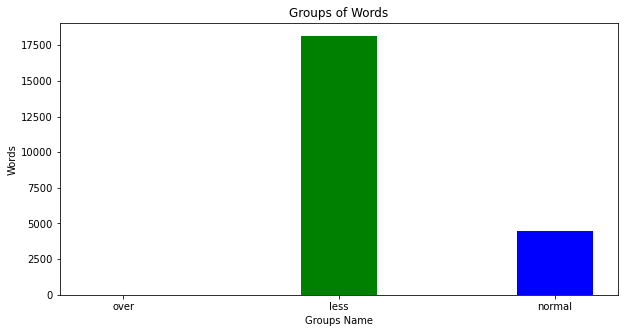

In [19]:
#ขั้นตอนนี่้จะเป็นการพรอทเพื่อดูลักษณะของคำ โดยทำการแบ่งกลุ่มออกเป็น 3 กลุ่ม คือ 1. over คือกลุ่มที่มีค่าความถี่สูง 2.normal กลุ่มที่มี่ความถี่คำปกติ
# 3. less กลุ่มที่มีความถี่ต่ำ
over = 0
less = 0
normal = 0

for word_fre in range(len(sorted_freque)): #ทำการวนลูปลบคำศัพท์ทั้งหมด
    if (int(sorted_freque[word_fre][1])  <= 10):#จากนั้นตั้งเงื่อนไขว่า ถ้าความถี่น้อยกว่าเท่ากับ 10 ให้ less + 1 
        less += 1
    elif (int(sorted_freque[word_fre][1]) > 1000):#หรือเงื่อนไขว่า ถ้ามากกว่า 1000 ให้ over + 1  
        over += 1
    else:                                         #ถ้าไม่ใช่ให้ normal + 1
        normal += 1
        
size = [over , less ,normal]       #จากนั้นนำทั้ง 3 กลุ่มมาสร้างเป็น list เพื่อใช้สำหรับการ plot
fig = plt.figure(figsize = (10, 5))  #กำหนดขนาดของ layout
plt.bar(['over','less','normal'],size, color =['blue','green'],  # ใช้คำสั่ง bar เพื่อทำการ plot bar graph
        width = 0.35)
plt.xlabel("Groups Name") 
plt.ylabel("Words") 
plt.title("Groups of Words") 

จากกราฟด้านบน ทำให้ทราบว่าข้อมูลชุดนี้ส่วนใหญ่ เป็นคำที่มีความถี่ในการใช้น้อยกว่า 10  ซึ่งจะนำผลการวิเคราะห์ความถี่ของคำไปใช้ในขั้นตอนการตัดคำต่อไป

## Text Preprocessing
จากการวิเคราะห์ความถี่ของคำ ทำให้ทราบลักษณะของคำมากขึ้น ในขั้นตอนการตัดคำเราจะแบ่งเป็น 2 กรณี เพื่อศึกษาว่าการตัดคำที่เหลือจำนวนคำเยอะ กับ จำนวนคำน้อย มีผลต่อความแม่นยำหรือไม่ และแบบไหนที่ทำให้โมเดลมีความแม่นยำเพิ่มขึ้น โดยในการตัดคำจะเน้นไปที่การตัดของคำที่มีความถี่น้อยเนื่องจากข้อมูลนี้ส่วนใหญ่เป็นคำที่มีความถี่น้อย จะแบ่งเป็น 2 กลุ่มดังนี้
    1. More_Words คือการตัดคำที่เหลือจำนวนคำเยอะ (min_df = 2)
    2. Less_Words คือการตัดคำที่เหลือจำนวนคำน้อย (min_df = 10)
โดยกระบวนการตัดคำจะแบ่งเป็น 3 รูปแบบดังนี้
    1. stem_tokenizer  เป็นกระบวนตัดส่วนท้ายของคำ
    2. lemma_tokenizer กระบวนการในการแปลง Word ด้วยรายการคำศัพท์ใน Dictionary 
    3. lemma_tokenizer_w_pos_tag เป็นกระบวนการในการระบุว่า คำไหน เป็นส่วนไหนของประโยค เช่น noun, pronoun, verb

In [20]:
#เป็นกระบวนตัดส่วนท้ายของคำ
def stem_tokenizer(text):
    standard_tokenizer = CountVectorizer().build_tokenizer() #เรียกใช้ฟังชั่น CountVectorizer
    tokens = standard_tokenizer(text)  #กำหนดตัวแปรไว้อ่านข้อมูล
    stemmer = PorterStemmer()          #เรียกใช้ฟังชั่น PorterStemmer
    stems = []
    for token in tokens:               #ทำการวนลูปข้อมูล
        stems.append( stemmer.stem(token.lower()) ) #แปลงข้อมูลเป็นตัวพิมเล็ก และตัดคำโดยใช้ stemmer  ตัดส่วนท้ายของคำ
    return stems

In [21]:
#กระบวนการในการแปลง Word ด้วยรายการคำศัพท์ใน Dictionary 
def lemma_tokenizer(text):
    standard_tokenizer = CountVectorizer().build_tokenizer()#เรียกใช้ฟังชั่น CountVectorizer
    tokens = standard_tokenizer(text)                      #กำหนดตัวแปรไว้อ่านข้อมูล
    lemmatizer = nltk.stem.WordNetLemmatizer()             # เรียกใช้ฟังชั่น WordNetLemmatizer
    lemma_tokens = []
    for token in tokens:                                   # #ทำการวนลูปข้อมูล
        lemma_tokens.append( lemmatizer.lemmatize(token))  #แปลงข้อมูลเป็นตัวพิมเล็ก และตัดคำโดยใช้ lemmatize 
    return lemma_tokens                                    # ในการแปลง Word ด้วยรายการคำศัพท์ใน Dictionary 

In [22]:
#เป็นกระบวนการในการระบุว่า คำไหน เป็นส่วนไหนของประโยค เช่น noun, pronoun, verb, adjective, adverb, preposition, conjunction
def lemma_tokenizer_w_pos_tag(text):
    def convert_tags(tag):                              #ทำการสร้างฟังชั่นที่ใช้สำหรับติด tag ข้อมูล ว่า เป็น verb หรือ noun
        if tag == 'vbd' or tag == 'vbg' or tag == 'vbz':
            return 'v'
        else: 
            return 'n'
    
  
    standard_tokenizer = CountVectorizer().build_tokenizer() #เรียกใช้ฟังชั่น CountVectorizer
    tokens = standard_tokenizer(text)                        #กำหนดตัวแปรไว้อ่านข้อมูล
    tokens_with_pos_tag = nltk.pos_tag(tokens)               # เรียกใช้ฟังชั่น pos_tag กับข้อมูล
    lemmatizer = nltk.WordNetLemmatizer()                    #เรียกใช้ฟังชั่น WordNetLemmatizer
    lemma_tokens = []
    for token in tokens_with_pos_tag:                        # ทำการวนลูปไปยังข้อมูลที่ติด tag
        new_tag = convert_tags(token[1].lower())             # ทำการแปลงข้อมูลเป็นตัวพิมเล็กและเรียกใช้งาน convert_tags 
        lemma_tokens.append(lemmatizer.lemmatize(token[0], new_tag))
    
    return lemma_tokens

### Choose  Tokenizer Process
ขั้นตอนนี้จะเป็นการเลือกวิธีการที่เหมาะสมสำหรับการตัดคำของแต่ละกลุ่ม โดยในการกำหนด min_df = 10 (Less_Words) มาจากขั้นตอนก่อนหน้าที่พบว่าคำส่วนใหญ่มีความถี่น้อยกว่า 10 จึงทดสอบลบทั้งหมด   อีกกรณีคือตัด min_df = 2 (More_Words) เกิดจากการคาดการว่าถ้าตัด 2 แสดงว่าเป็นคำที่ข่าวไม่ค่อยพูดหรือไม่ใช่ส่วนสำคัญของข่าว 

#### Less_Words

In [23]:
#ขั้นตอนนี้จะเป็นการวนลูปเพื่อหาวิธีการที่สามารถตัดคำให้เหลือน้อยที่สุดจาก 3 วิธีการ
list_token = [stem_tokenizer,lemma_tokenizer,lemma_tokenizer_w_pos_tag] #ขั้นตอนแรกสร้าง list ของแต่ละวิธีการตัดคำ
for i in list_token:                                                    #จากนั้นทำการวนลูปการทำงานของแต่ละวิธีการ
    vectorizer = TfidfVectorizer(stop_words="english",min_df = 10, tokenizer= i) #เรียกใช้คำสั่ง TfidfVectorizer เพื่อใช้ในการตัดคำโดย
    X = vectorizer.fit_transform(text_body)                     #กำหนดเงือนไขว่าต้องตัดคำที่อยู่ใน list ที่ชื่อ english และตัดคำที่มี
                                #ความถี่คำน้อยกว่า 10 และเรียกใช้ กระบวนการตัดคำตามลูป เช่น ลูปรอบที่ 1 ใช้วิธีการตัดแบบ stem_tokenizer                               
    print(str(i)+': '+str(X.shape)) #แสดงวิธีการ จำนวนข้อมูลข่าว และจำนวนคำศัพท์

<function stem_tokenizer at 0x00000222A3501CA0>: (1408, 3166)
<function lemma_tokenizer at 0x00000222A350F040>: (1408, 3664)
<function lemma_tokenizer_w_pos_tag at 0x00000222A350F310>: (1408, 3485)


ในส่วนของ Less_Words จะเลือกวิธีการที่สามารถทำให้คำเหลือน้อย จากข้อมูลด้านบน การตัดคำโดยใช้ stem_tokenizer นั้นจะทำให้มีจำนวนคำศัพท์เหลือน้อยที่สุด
จึงเลือกใช้ stem_tokenizer สำหรับกลุ่ม Less_Words

In [24]:
vectorizer = TfidfVectorizer(stop_words="english",min_df = 10, tokenizer= stem_tokenizer) #เรียกใช้ TfidfVectorizer กับกระบวนการ
weight_X = vectorizer.fit_transform(text_body)           #stem_tokenizer หลังจากนั้นใช้คำสั่ง fit เพื่อทำงานกับข้อมูล text_body 
weight_X.shape                                          # แสดงจำนวนข้อมูลข่าว และจำนวนคำศัพท์

(1408, 3166)

#### More_Words

In [25]:
#ขั้นตอนนี้จะเป็นการวนลูปเพื่อหาวิธีการที่สามารถตัดคำให้เหลือมากที่สุดจาก 3 วิธีการ
list_token1 = [stem_tokenizer,lemma_tokenizer,lemma_tokenizer_w_pos_tag] #ขั้นตอนแรกสร้าง list ของแต่ละวิธีการตัดคำ
for i in list_token1:                                                   #จากนั้นทำการวนลูปการทำงานของแต่ละวิธีการ
    vectorizer = TfidfVectorizer(stop_words="english",min_df = 2, tokenizer= i)#เรียกใช้คำสั่ง TfidfVectorizer เพื่อใช้ในการตัดคำโดย
    X_1 = vectorizer.fit_transform(text_body)                    #กำหนดเงือนไขว่าต้องตัดคำที่อยู่ใน list ที่ชื่อ english และตัดคำที่มี
                                     #ความถี่คำน้อยกว่า 5 และเรียกใช้ กระบวนการตัดคำตามลูป เช่น ลูปรอบที่ 1 ใช้วิธีการตัดแบบ stem_tokenizer
    print(str(i)+': '+str(X_1.shape))  #แสดงจำนวนข้อมูลข่าว และจำนวนคำศัพท์

<function stem_tokenizer at 0x00000222A3501CA0>: (1408, 9187)
<function lemma_tokenizer at 0x00000222A350F040>: (1408, 11765)
<function lemma_tokenizer_w_pos_tag at 0x00000222A350F310>: (1408, 11080)


ในส่วนของ More_Words จะเลือกวิธีการที่สามารถทำให้มีคำเหลือมากที่สุด จากข้อมูลด้านบนพบว่าการใช้ Lema_tokenizer จะทำให้มีจำนวนคำที่เยอะที่สุด จึงเลือกใช้ Lema_tokenizer สำหรับ More_Words

In [26]:
vectorizer = TfidfVectorizer(stop_words="english",min_df = 2, tokenizer=lemma_tokenizer)#เรียกใช้ TfidfVectorizer กับกระบวนการ
weight_X1 = vectorizer.fit_transform(text_body)          #lemma_tokenizer หลังจากนั้นใช้คำสั่ง fit เพื่อทำง่านกับข้อมูล text_body 
weight_X1.shape                                          # แสดงจำนวนข้อมูลข่าว และจำนวนคำศัพท์

(1408, 11765)

# Algorithm - Comparison
จะเป็นขั้นตอนการเปรียบเทียบอัลกอริทึมของทั้ง 2 กลุ่ม  เพื่อพิสูจน์ว่าอัลกอริทึมแบบที่เหมาะสมกับข้อมูลชุดนี้ โดยในการทดลองครั้งนี้จะใช้ K-Fold Cross-validation แบบ Inner ในการทดสอบกับโมเดล เนื่องจากการทำ K-Fold จะช่วยให้ข้อมูลในแต่ละ fold มีการกระจายตัวใกล้เคียงกันช่วยลด bias เวลาสร้างและทดสอบโมเดล อีกทั้งยังสามารถนำ K-Fold Cross-validation มาใช้ในการเปรียบเทียบอัลกอรึทึมเพื่้อหาอัลกอรึทึมที่ดีที่สุด

### Feature and Target
ขั้นตอนกำหนด feature และ target ของแต่ละกลุ่ม โดยมีทั้งหมด 2 กลุ่ม 

1. Less_Words

In [27]:
feature = weight_X                                      #กำหนด feature เป็นข้อมูลที่ถ่วงน้ำหนักของกลุ่ม Less_Words
target = data['Category'].replace({'business':0, 'technology':1 , 'sport':2}) #กำหนด target เป็นคอลัม category และทำการแปลง
                                                                 # target string ให้เป็น integer 

 2. More_Words

In [28]:
feature_1 = weight_X1                                                   # #กำหนด feature เป็นข้อมูลที่ถ่วงน้ำหนักของกลุ่ม More_Words
target_1 = data['Category'].replace({'business':0, 'technology':1 , 'sport':2}) #กำหนด target เป็นคอลัม category และทำการแปลง
                                                                         # target string ให้เป็น integer 

### Training and test sets
ขั้นตอนการแบ่งข้อมูลเป็น 2 ส่วน คือ Train 70 % และ Test 30 %  และกำหนด random_state = 1 เพื่อให้ทุกครั้งที่สุ่มแบ่งข้อมูลจะได้ข้อมูลในลักษณะเดิม โดยในขั้นตอนนี้จะมีข้อมูลทั้งหมด 2 ชุด และทั้ง 2 ชุดจะถูกเซ็ทค่าต่างๆ เหมือนกัน เพื่อป้องกันความผิดพลาดในเรื่องความแตกต่างของชุดข้อมูล
- ข้อมูลชุดที่ 1 เป็นของกลุ่ม Less_Words ใช้สำหรับทำการทดลอง
- ข้อมูลชุดที่ 2 เป็นของกลุ่ม More_Words ใช้สำหรับทำการทดลอง

In [29]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.30 , random_state = 1) #Less_Words

In [30]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(feature_1, target_1, test_size=0.30 , random_state = 1) #More_words

### Model
ขั้นตอนนี้จะเป็นการเปรีบเทียบอัลกอรึทึมของแต่ละกลุ่ม เพื่อหาอัลกอรึทึมที่ดีที่สุดและรูปแบบการตัดคำที่สามารถให้ความแม่นยำสูงสุดไปใช้ในการสร้างโมเดล โดยอัลกอรึทึมที่ใช้ในการทดสอบครั้งนี้มีดังนี้
    1. LogisticRegression                       
    2. BernoulliNB
    3. ComplementNB
    4. MultinomialNB
    5. Support vector machine
    6. RandomForestClassifier
และรูปแบบการตัดคำจะมี 2 กลุ่มดังนี้<br>
    1. Less_Words คือกลุ่มที่ตัดคำให้เหลือคำน้อย
    2. More_Words คือกลุ่มที่ตัดคำให้เหลือคำเยอะ

In [31]:
models = [LogisticRegression() , BernoulliNB(),ComplementNB(), MultinomialNB()  , svm.SVC(),\
          RandomForestClassifier()] #สร้าง list ของ Model 

In [32]:
Listname_model = ['LogisticRegression','BernoulliNB','ComplementNB','MultinomialNB','SVM',\
                 'RandomForestClassifier']  #สร้าง list ของ ชื่อโมเดล

In [33]:
parameter = [ {'penalty':('l1', 'l2', 'elasticnet', 'none'),              #สร้าง list parameter ของแต่ละโมเดลขึ้นมา      
              'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')},
            {'alpha':[1.0 ,10.0]},
            {'alpha':[1.0 ,10.0]},
            {'alpha':[1.0 ,10.0]},
            {'kernel':('linear', 'rbf'), 'C':[1, 10]},
            {'max_features':('auto', 'sqrt', 'log2'),'criterion':('gini', 'entropy')}]

In [34]:
kfold_inner = KFold(n_splits=15, random_state=1, shuffle=True)          #กำหนดค่าในการทำ k-foldแบบ inner ว่าแบ่งข้อมูลเป็น 15 ส่วน

#### Less_Words

In [35]:
count = 0
Score_model_10 = dict()                                                 #สร้าง dict เพื่อไว้ใข้ในการเก็บค่าความแม่นยำของแต่ละอัลกอรึทึม
print('--------  Accuracy and Best_parameter (Less Words) ----------')
for model in models:                                                   #ทำการวนลูปเข้าแต่ละอัลกอรึทึม
    bestmodel = GridSearchCV(model, parameter[count],return_train_score = True, cv= kfold_inner) #จากนั้นใช้ GridSeachCV เพื่อทำ 
    bestmodel.fit(X_train, y_train)                                # k-fold crossvalidation และ หา parameter ที่เหมาะกับอัลกอรึทึม
    Score_model_10[Listname_model[count]] =  bestmodel.best_score_ #นำ accuracy ของแต่ละอัลกอรึทึมเก็บเข้า dict เพื่อใช้ในการ plot
    print(Listname_model[count]+":  ")
    print('Cross_validation :  '+'%.3f' %(bestmodel.best_score_))
    print('best_parameter:  '+str(bestmodel.best_params_))
    print('')
    count += 1


--------  Accuracy and Best_parameter (Less Words) ----------
LogisticRegression:  
Cross_validation :  0.987
best_parameter:  {'penalty': 'none', 'solver': 'lbfgs'}

BernoulliNB:  
Cross_validation :  0.974
best_parameter:  {'alpha': 1.0}

ComplementNB:  
Cross_validation :  0.978
best_parameter:  {'alpha': 1.0}

MultinomialNB:  
Cross_validation :  0.981
best_parameter:  {'alpha': 1.0}

SVM:  
Cross_validation :  0.986
best_parameter:  {'C': 10, 'kernel': 'linear'}

RandomForestClassifier:  
Cross_validation :  0.976
best_parameter:  {'criterion': 'gini', 'max_features': 'log2'}



#### More_Words

In [36]:
count = 0
Score_model_5 = dict()                                                #สร้าง dict เพื่อไว้ใข้ในการเก็บค่าความแม่นยำของแต่ละอัลกอรึทึม
print('--------  Accuracy and Best_parameter (More words)----------')
for model in models:                                                   #ทำการวนลูปเข้าแต่ละอัลกอรึทึม
    bestmodel1 = GridSearchCV(model, parameter[count],return_train_score = True, cv= kfold_inner) #จากนั้นใช้ GridSeachCV เพื่อทำ 
    bestmodel1.fit(X_train1, y_train1)                               # k-fold crossvalidation และ หา parameter ที่เหมาะกับอัลกอรึทึม
    Score_model_5[Listname_model[count]] = bestmodel1.best_score_    # #นำ accuracy ของแต่ละอัลกอรึทึมเก็บเข้า dict เพื่อใช้ในการ plot
    print(Listname_model[count]+":  ")
    print('Cross_validation :  '+'%.3f' %(bestmodel1.best_score_))
    print('best_parameter:  '+str(bestmodel1.best_params_))
    print('')
    count += 1

--------  Accuracy and Best_parameter (More words)----------
LogisticRegression:  
Cross_validation :  0.984
best_parameter:  {'penalty': 'none', 'solver': 'sag'}

BernoulliNB:  
Cross_validation :  0.979
best_parameter:  {'alpha': 1.0}

ComplementNB:  
Cross_validation :  0.979
best_parameter:  {'alpha': 1.0}

MultinomialNB:  
Cross_validation :  0.977
best_parameter:  {'alpha': 1.0}

SVM:  
Cross_validation :  0.983
best_parameter:  {'C': 10, 'kernel': 'linear'}

RandomForestClassifier:  
Cross_validation :  0.974
best_parameter:  {'criterion': 'gini', 'max_features': 'auto'}



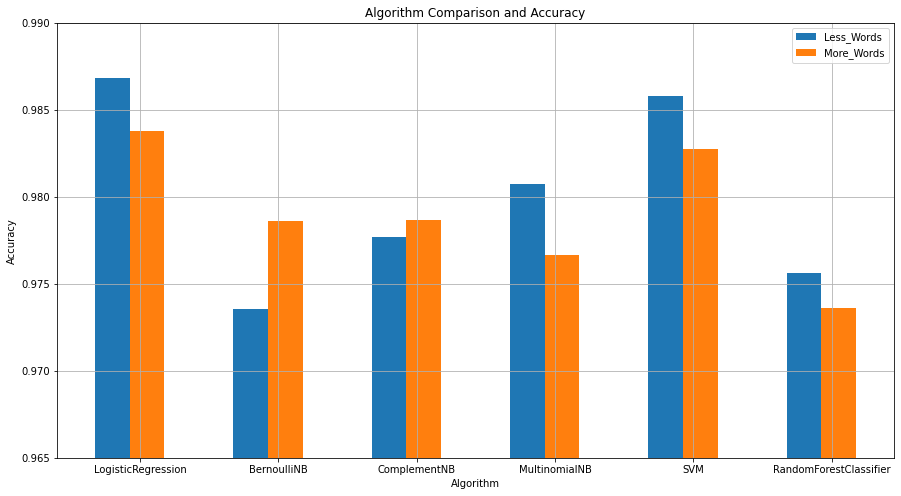

In [37]:
data_score_less = pd.DataFrame.from_dict(Score_model_10,orient='index',columns=['Less_Words']) #สร้าง dataframe ข้อมูลความแม่นยำของกลุ่ม Less words
data_score_more = pd.DataFrame.from_dict(Score_model_5,orient='index')  #สร้าง dataframe ข้อมูลความแม่นยำของกลุ่ม More words
data_score_less['More_Words'] = data_score_more                        #จากนั้นนำ dataframe ทั้ง 2 มา join กัน 
data_score = data_score_less                                          # และตั้งชื่อว่า data_score

bar_width = 0.25                                                     #กำหนดขนาดของแท่งกราฟ
fig, ax = plt.subplots(figsize = (15,8))                             #กำหนดพื้นที่ layout
plt.bar(np.arange(len(data_score)), data_score['Less_Words'], bar_width, label='Less_Words')  #ทำการแท่งกราฟของข้อมูล Less_Words
plt.bar(np.arange(len(data_score))+bar_width, data_score['More_Words'],\
                bar_width ,label = 'More_Words')                    #ทำการแท่งกราฟของข้อมูล More_Words
plt.ylim(0.965,0.990)
plt.xticks((0.2,1.2,2.2,3.2,4.2,5.2),data_score.index)
plt.title('Algorithm Comparison and Accuracy')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()


จากกราฟด้านบนแสดงให้เห็นว่า ในการตัดคำที่ทำให้เหลือคำเยอะหรือน้อยมีผลกับความแม่นยำของโมเดล แต่ไม่สามารถบอกได้ว่าการตัดคำแบบไหนที่สามารถทำให้ความแม่นยำของโมเดลเพิ่มขึ้น ทั้งนี้ขึ้นอยู่กับคุณลักษณะของแต่ละโมเดล  โดยอัลกอรึทึมทีดีที่สุดกับข้อมูลชุดนี้คือ LogisticRegression และใช้การตัดคำแบบ Less Words และจะนำไปใช้ในการสร้างโมเดลในขั้นตอนต่อไป

# Choose The Best Model
จะเป็นขั้นตอนการเลือกอัลกอรึทึมที่ดีที่สุดมาใช้ในการสร้างโมเดล โดยในขั้นตอนนี้เลือกใช้  LogisticRegression เนื่อกจากเป็นอัลกอรึทึมที่สามารถทำนายได้ความแม่นยำสูงสุด และ เลือกใช้กระบวนการตัดคำแบบ Less_Words

In [38]:
LOG_Model = LogisticRegression(penalty= 'none', solver= 'lbfgs') #ให้เรียกใช้โมเดล Logistic พร้อมทั้งระบุ best parameter ลงโมเดล
LOG_Model.fit(X_train, y_train)                                  #จากนั้นใช้คำสั้ง fit เพื่อให้โมเดลเรียนรู้ข้อมูล

LogisticRegression(penalty='none')

In [39]:
predict = LOG_Model.predict(X_test) #ทดลองทำนาย
predict

array([2, 1, 2, 2, 0, 0, 2, 1, 0, 0, 1, 0, 2, 2, 0, 1, 1, 0, 1, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 1, 0, 2, 0, 1, 0, 1,
       1, 2, 0, 0, 1, 2, 2, 1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 1,
       0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2,
       1, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0,
       2, 0, 2, 1, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0,
       0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 1,
       1, 0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 2, 1,
       0, 1, 2, 2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 1, 0, 0,
       2, 1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 2, 2, 0, 1, 2, 1, 1, 2,
       1, 0, 2, 2, 1, 0, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 0, 2,
       2, 2, 0, 0, 1, 1, 2, 0, 2, 2, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2,
       1, 1, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0,

In [40]:
accuracy_SVM = accuracy_score(y_test, predict) #ตรวจสอบความแม่นยำของโมเดล
accuracy_SVM

0.9763593380614657

In [41]:
precision_SVM = precision_score(y_test, predict ,  average= 'micro' ) #ตรวจสอบความแม่นยำของโมเดลในมุมของ precision
precision_SVM

0.9763593380614657

In [42]:
recall_SVM =  recall_score(y_test, predict ,  average= 'micro' ) #ตรวจสอบความแม่นยำของโมเดลในมุมของ recall
recall_SVM

0.9763593380614657

In [43]:
conf_mtx_SVM = confusion_matrix(y_test, predict) #สร้างตารางการทำนาย
conf_mtx_SVM

array([[147,   1,   1],
       [  4, 116,   2],
       [  2,   0, 150]], dtype=int64)

ทดสอบการ Cross-validation กับข้อมูลทั้งหมดเพื่อศึกษาว่าข้อมูลชุดนี้มีความแม่นยำเท่าไหร่

In [44]:
cross_val_score(LOG_Model,feature,target ,cv = kfold_inner, scoring='accuracy').mean()#เป็นการทดสอบว่าข้อมูลชุดนี้สามารถทำนายความแม่นยำได้เท่าไหร่ 
                                                          #โดยใช้โมเดล LogisticRegression

0.9829482193243346

# Summary

จากการทดสอบข้อมูลข่าวชุดนี้ พบว่าคำศัพท์ในข่าวส่วนใหญ่เป็นคำที่มีความถี่น้อยกว่า 10 ครั้ง ซึ่งมีมากถึง 86 % โดยการที่ข่าวชุดนี้มีความถี่ของคำน้อยมีทั้งข้อดีและข้อเสียดังนี้ 
   * ข้อดี คือ คำศัพท์ที่มีความถี่น้อยแสดงให้เห็นถึงลักษณะการแบ่งแยกของเนื้อหาข่าวที่ชัดเจน เช่น ข่าวนี้พูดถึงชื่อนักแสดง ซึ่งชื่อนักแสดงมีความถี่ในการใช้น้อย ทำให้       สามารถระบุได้ง่ายว่าพูดถึงข่าวไหนใน Corpus นั้น
   
   * ข้อเสีย คือ คำศัพท์ที่มีความถี่น้อยอาจจะแสดงให้เห็นถึง คำๆ นั้นอาจถูกพูดถึงน้อย หรือใช่สาระสำคัญของข่าว
   
   
จากข้อดีและข้อเสียดังกล่าว ทำให้เกิดการตั้งสมมุติฐานขึ้นมาว่า การตัดคำศัพท์ที่มีความถี่น้อยให้เหลือจำนวนคำมากใน Copus กับ ให้เหลือจำนวนคำน้อย แบบไหนดีกว่ากันและแบบไหนที่ทำให้โมเดลมีความแม่นยำเพิ่มขึ้น จึงทำการทดลองโดยสร้างรูปแบบการตัดคำมา 2 แบบ คือ 
    1. Less_Words คือการตัดคำให้จำนวนคำน้อย 
    2. More_Words คือการตัตคำให้เหลือจำนวนคำเยอะ
  
และทำการทดลองพบว่า ในการตัดคำที่ทำให้เหลือคำเยอะหรือน้อยมีผลกับความแม่นยำของโมเดล แต่ไม่สามารถบอกได้ว่าการตัดคำแบบไหนที่สามารถทำให้ความแม่นยำของโมเดลเพิ่มขึ้น ขึ้นอยู่กับคุณลักษณะการทำงานของแต่ละโมเดล ทั้งนี้เพราะว่าบางโมเดลความแม่นยำเพิ่มขึ้นแต่ในทางตรงกันข้าม    บางโมเดลกับมีความแม่นยำน้อยลงอย่างเห็นได้ชัด ในภาพรวมการตัดคำที่ทำให้เหลือคำน้อยค่อนข้างดีกว่าการตัดคำให้เหลือคำเยอะ 
โดยอัลกอรึทึมที่เหมาะสมกับการทดลองครั้งนี้คือ Logistic Regression   สำหรับข้อมูลชุดนี้สามารถทำให้โมเดลความแม่นยำได้ 98.29 % 
 